# Machine Translation English-German Example Using SageMaker Seq2Seq

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Download dataset and preprocess](#Download-dataset-and-preprocess)
3. [Training the Machine Translation model](#Training-the-Machine-Translation-model)
4. [Inference](#Inference)

## Introduction

Welcome to our Machine Translation end-to-end example! In this demo, we will train a English-German translation model and will test the predictions on a few examples.

SageMaker Seq2Seq algorithm is built on top of [Sockeye](https://github.com/awslabs/sockeye), a sequence-to-sequence framework for Neural Machine Translation based on MXNet. SageMaker Seq2Seq implements state-of-the-art encoder-decoder architectures which can also be used for tasks like Abstractive Summarization in addition to Machine Translation.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Setup

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. **This should be within the same region as the Notebook Instance, training, and hosting.**
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp in the cell below with a the appropriate full IAM role arn string(s).

In [2]:
# S3 bucket and prefix
bucket = 'fab-sagemaker'
prefix = 'seq2seq-translation'

In [3]:
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [4]:
from time import gmtime, strftime
import time
import numpy as np
import os
import json

# For plotting attention matrix later on
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Download dataset and preprocess

In this notebook, we will train a English to German translation model on a dataset from the
[Conference on Machine Translation (WMT) 2017](http://www.statmt.org/wmt17/).

In [5]:
%%bash
wget http://data.statmt.org/wmt17/translation-task/preprocessed/de-en/corpus.tc.de.gz & \
wget http://data.statmt.org/wmt17/translation-task/preprocessed/de-en/corpus.tc.en.gz & wait
gunzip corpus.tc.de.gz & \
gunzip corpus.tc.en.gz & wait
mkdir validation
curl http://data.statmt.org/wmt17/translation-task/preprocessed/de-en/dev.tgz | tar xvzf - -C validation

newstest2014-deen-ref.de.sgm
newstest2014-deen-ref.en.sgm
newstest2014-deen-src.de.sgm
newstest2014-deen-src.en.sgm
newstest2014.tc.de
newstest2014.tc.en
newstest2015-deen-ref.en.sgm
newstest2015-deen-src.de.sgm
newstest2015-ende-ref.de.sgm
newstest2015-ende-src.en.sgm
newstest2015.tc.de
newstest2015.tc.en
newstest2016-deen-ref.en.sgm
newstest2016-deen-src.de.sgm
newstest2016-ende-ref.de.sgm
newstest2016-ende-src.en.sgm
newstest2016.tc.de
newstest2016.tc.en


--2020-10-12 14:33:22--  http://data.statmt.org/wmt17/translation-task/preprocessed/de-en/corpus.tc.en.gz
--2020-10-12 14:33:22--  http://data.statmt.org/wmt17/translation-task/preprocessed/de-en/corpus.tc.de.gz
Resolving data.statmt.org (data.statmt.org)... Resolving data.statmt.org (data.statmt.org)... 129.215.197.184129.215.197.184

Connecting to data.statmt.org (data.statmt.org)|129.215.197.184|:80... Connecting to data.statmt.org (data.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263407937 (251M) [application/x-gzip]
Saving to: ‘corpus.tc.en.gz’

     0K .......... ...200 OK
Length: 299680879 (286M) [application/x-gzip]
Saving to: ‘corpus.tc.de.gz’

     0K .......... .......... .......... .......... ......... .......... .......... ..........  0%  285K 15m2s
    50K .......... .......... .......... .......... ................  0%  284K 17m12s
    50K .......... .......... ...

Please note that it is a common practise to split words into subwords using Byte Pair Encoding (BPE). Please refer to [this](https://github.com/awslabs/sockeye/tree/master/tutorials/wmt) tutorial if you are interested in performing BPE.

Since training on the whole dataset might take several hours/days, for this demo, let us train on the **first 10,000 lines only**. Don't run the next cell if you want to train on the complete dataset.

In [6]:
!head -n 10000 corpus.tc.en > corpus.tc.en.small
!head -n 10000 corpus.tc.de > corpus.tc.de.small

Now, let's use the preprocessing script `create_vocab_proto.py` (provided with this notebook) to create vocabulary mappings (strings to integers) and convert these files to x-recordio-protobuf as required for training by SageMaker Seq2Seq.  
Uncomment the cell below and run to see check the arguments this script expects.

In [7]:
%%bash
python3 create_vocab_proto.py -h

usage: create_vocab_proto.py [-h] -ts TRAIN_SOURCE -tt TRAIN_TARGET
                             [-vs VAL_SOURCE] [-vt VAL_TARGET]
                             [-to TRAIN_OUTPUT] [-vo VAL_OUTPUT]
                             [-single-vocab]
                             [--vocab-source-json VOCAB_SOURCE_JSON]
                             [--vocab-target-json VOCAB_TARGET_JSON]
                             [--num-words-source NUM_WORDS_SOURCE]
                             [--num-words-target NUM_WORDS_TARGET]
                             [--word-min-count-source WORD_MIN_COUNT_SOURCE]
                             [--word-min-count-target WORD_MIN_COUNT_TARGET]

CLI to build vocabulary and pre-process input file.

optional arguments:
  -h, --help            show this help message and exit
  -vs VAL_SOURCE, --val-source VAL_SOURCE
                        Validation source file.
  -vt VAL_TARGET, --val-target VAL_TARGET
                        Validation target file.
  -to TRAIN_OUTPUT, --t

The cell below does the preprocessing. If you are using the complete dataset, the script might take around 10-15 min on an m4.xlarge notebook instance. Remove ".small" from the file names for training on full datasets.

In [8]:
%%time
%%bash
python3 create_vocab_proto.py \
        --train-source corpus.tc.en.small \
        --train-target corpus.tc.de.small \
        --val-source validation/newstest2014.tc.en \
        --val-target validation/newstest2014.tc.de

INFO:__main__:Building vocabulary from dataset: corpus.tc.en.small and corpus.tc.de.small
INFO:__main__:Final vocabulary: 10661 types (min frequency 1, top 50000 types)
INFO:__main__:Final vocabulary: 15980 types (min frequency 1, top 50000 types)
INFO:__main__:Source vocabulary size: 10661 
INFO:__main__:Vocabulary saved to "vocab.src.json"
INFO:__main__:Target vocabulary size: 15980 
INFO:__main__:Vocabulary saved to "vocab.trg.json"
INFO:__main__:Spawning 3 encoding worker(s) for encoding train datasets!
INFO:__main__:Processed 10000 lines for encoding to protobuf. 0 lines were ignored as they didn't have
                any content in either the source or the target file!
INFO:__main__:Completed writing the encoding queue!
INFO:__main__:Encoding finished! Writing records to "train.rec"
INFO:__main__:Processed input and saved to "train.rec"
INFO:__main__:Spawning 3 encoding worker(s) for encoding validation datasets!
INFO:__main__:Processed 3003 lines for encoding to protobuf. 0 lin

CPU times: user 1.36 ms, sys: 7.39 ms, total: 8.75 ms
Wall time: 1.62 s


The script will output 4 files, namely:
- train.rec : Contains source and target sentences for training in protobuf format
- val.rec : Contains source and target sentences for validation in protobuf format
- vocab.src.json : Vocabulary mapping (string to int) for source language (English in this example)
- vocab.trg.json : Vocabulary mapping (string to int) for target language (German in this example)

Let's upload the pre-processed dataset and vocabularies to S3

In [9]:
def upload_to_s3(bucket, prefix, channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = prefix + "/" + channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

upload_to_s3(bucket, prefix, 'train', 'train.rec')
upload_to_s3(bucket, prefix, 'validation', 'val.rec')
upload_to_s3(bucket, prefix, 'vocab', 'vocab.src.json')
upload_to_s3(bucket, prefix, 'vocab', 'vocab.trg.json')

In [10]:
region_name = boto3.Session().region_name

In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region_name, 'seq2seq')

print('Using SageMaker Seq2Seq container: {} ({})'.format(container, region_name))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker Seq2Seq container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/seq2seq:1 (us-east-1)


## Training the Machine Translation model

In [12]:
job_name = 'DEMO-seq2seq-en-de-' + strftime("%Y-%m-%d-%H", gmtime())
print("Training job", job_name)

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "ResourceConfig": {
        # Seq2Seq does not support multiple machines. Currently, it only supports single machine, multiple GPUs
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge", # We suggest one of ["ml.p2.16xlarge", "ml.p2.8xlarge", "ml.p2.xlarge"]
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        # Please refer to the documentation for complete list of parameters
        "max_seq_len_source": "60",
        "max_seq_len_target": "60",
        "optimized_metric": "bleu",
        "batch_size": "64", # Please use a larger batch size (256 or 512) if using ml.p2.8xlarge or ml.p2.16xlarge
        "checkpoint_frequency_num_batches": "1000",
        "rnn_num_hidden": "512",
        "num_layers_encoder": "1",
        "num_layers_decoder": "1",
        "num_embed_source": "512",
        "num_embed_target": "512",
        "checkpoint_threshold": "3",
        "max_num_batches": "2100"
        # Training will stop after 2100 iterations/batches.
        # This is just for demo purposes. Remove the above parameter if you want a better model.
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 48 * 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "vocab",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/vocab/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        }
    ]
}

sagemaker_client = boto3.Session().client(service_name='sagemaker')
sagemaker_client.create_training_job(**create_training_params)

status = sagemaker_client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

Training job DEMO-seq2seq-en-de-2020-10-12-14
InProgress


In [16]:
status = sagemaker_client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
# if the job failed, determine why
if status == 'Failed':
    message = sagemaker_client.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

Completed


> Now wait for the training job to complete and proceed to the next step after you see model artifacts in your S3 bucket.

You can jump to [Use a pretrained model](#Use-a-pretrained-model) as training might take some time.

## Inference

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means translating sentence(s) from English to German.
This section involves several steps,
- Create model - Create a model using the artifact (model.tar.gz) produced by training
- Create Endpoint Configuration - Create a configuration defining an endpoint, using the above model
- Create Endpoint - Use the configuration to create an inference endpoint.
- Perform Inference - Perform inference on some input data using the endpoint.

### Create model
We now create a SageMaker Model from the training output. Using the model, we can then create an Endpoint Configuration.

In [17]:
use_pretrained_model = False

### Use a pretrained model
#### Please uncomment and run the cell below if you want to use a pretrained model, as training might take several hours/days to complete.

In [18]:
#use_pretrained_model = True
#model_name = "DEMO-pretrained-en-de-model"
#!curl https://s3-us-west-2.amazonaws.com/seq2seq-data/model.tar.gz > model.tar.gz
#!curl https://s3-us-west-2.amazonaws.com/seq2seq-data/vocab.src.json > vocab.src.json
#!curl https://s3-us-west-2.amazonaws.com/seq2seq-data/vocab.trg.json > vocab.trg.json
#upload_to_s3(bucket, prefix, 'pretrained_model', 'model.tar.gz')
#model_data = "s3://{}/{}/pretrained_model/model.tar.gz".format(bucket, prefix)

In [19]:
%%time

sage = boto3.client('sagemaker')

if not use_pretrained_model:
    info = sage.describe_training_job(TrainingJobName=job_name)
    model_name=job_name
    model_data = info['ModelArtifacts']['S3ModelArtifacts']

print(model_name)
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-seq2seq-en-de-2020-10-12-14
s3://fab-sagemaker/seq2seq-translation/DEMO-seq2seq-en-de-2020-10-12-14/output/model.tar.gz
arn:aws:sagemaker:us-east-1:640463227255:model/demo-seq2seq-en-de-2020-10-12-14
CPU times: user 42.1 ms, sys: 0 ns, total: 42.1 ms
Wall time: 1.61 s


### Create endpoint configuration
Use the model to create an endpoint configuration. The endpoint configuration also contains information about the type and number of EC2 instances to use when hosting the model.

Since SageMaker Seq2Seq is based on Neural Nets, we could use an ml.p2.xlarge (GPU) instance, but for this example we will use a free tier eligible ml.m4.xlarge.

In [20]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-Seq2SeqEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-Seq2SeqEndpointConfig-2020-10-12-15-14-56
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:640463227255:endpoint-config/demo-seq2seqendpointconfig-2020-10-12-15-14-56


### Create endpoint
Lastly, we create the endpoint that serves up model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 10-15 minutes to complete.

In [21]:
%%time
import time

endpoint_name = 'DEMO-Seq2SeqEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sage.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sage.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

# wait until the status has changed
sage.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sage.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

DEMO-Seq2SeqEndpoint-2020-10-12-15-14-59
arn:aws:sagemaker:us-east-1:640463227255:endpoint/demo-seq2seqendpoint-2020-10-12-15-14-59
Status: Creating
Endpoint creation ended with EndpointStatus = InService
CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 8min 32s


If you see the message,
> Endpoint creation ended with EndpointStatus = InService

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.  

We will finally create a runtime object from which we can invoke the endpoint.

In [22]:
runtime = boto3.client(service_name='runtime.sagemaker') 

# Perform Inference

### Using JSON format for inference (Suggested for a single or small number of data instances)

#### Note that you don't have to convert string to text using the vocabulary mapping for inference using JSON mode

In [23]:
sentences = ["you are so good !",
             "can you drive a car ?",
             "i want to watch a movie ."
            ]

payload = {"instances" : []}
for sent in sentences:
    payload["instances"].append({"data" : sent})

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)
print(response)

{'predictions': [{'target': 'grenzüberschreitende sind ,'}, {'target': 'die Nachfrage kann , ?'}, {'target': 'Jessica ist die staatliche Entwicklungsbank , das ein Programm zur Verfügung .'}]}


### Retrieving the Attention Matrix

Passing `"attention_matrix":"true"` in `configuration` of the data instance will return the attention matrix.

In [24]:
sentence = 'can you drive a car ?'

payload = {"instances" : [{
                            "data" : sentence,
                            "configuration" : {"attention_matrix":"true"}
                          }
                         ]}

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)['predictions'][0]

source = sentence
target = response["target"]
attention_matrix = np.array(response["matrix"])

print("Source: %s \nTarget: %s" % (source, target))

Source: can you drive a car ? 
Target: die Nachfrage kann , ?


In [25]:
# Define a function for plotting the attentioan matrix
def plot_matrix(attention_matrix, target, source):
    source_tokens = source.split()
    target_tokens = target.split()
    assert attention_matrix.shape[0] == len(target_tokens)
    plt.imshow(attention_matrix.transpose(), interpolation="nearest", cmap="Greys")
    plt.xlabel("target")
    plt.ylabel("source")
    plt.gca().set_xticks([i for i in range(0, len(target_tokens))])
    plt.gca().set_yticks([i for i in range(0, len(source_tokens))])
    plt.gca().set_xticklabels(target_tokens)
    plt.gca().set_yticklabels(source_tokens)
    plt.tight_layout()

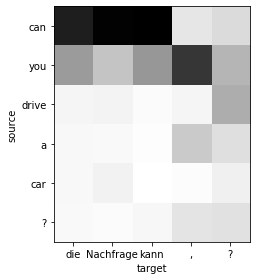

In [26]:
plot_matrix(attention_matrix, target, source)

### Using Protobuf format for inference (Suggested for efficient bulk inference)

Reading the vocabulary mappings as this mode of inference accepts list of integers and returns list of integers.

In [27]:
import io
import tempfile
from record_pb2 import Record
from create_vocab_proto import vocab_from_json, reverse_vocab, write_recordio, list_to_record_bytes, read_next

source = vocab_from_json("vocab.src.json")
target = vocab_from_json("vocab.trg.json")

source_rev = reverse_vocab(source)
target_rev = reverse_vocab(target)

INFO:create_vocab_proto:Vocabulary (10661 words) loaded from "vocab.src.json"
INFO:create_vocab_proto:Vocabulary (15980 words) loaded from "vocab.trg.json"


In [28]:
sentences = ["this is so cool",
            "i am having dinner .",
            "i am sitting in an aeroplane .",
            "come let us go for a long drive ."]

Converting the string to integers, followed by protobuf encoding:

In [29]:
# Convert strings to integers using source vocab mapping. Out-of-vocabulary strings are mapped to 1 - the mapping for <unk>
sentences = [[source.get(token, 1) for token in sentence.split()] for sentence in sentences]
f = io.BytesIO()
for sentence in sentences:
    record = list_to_record_bytes(sentence, [])
    write_recordio(f, record)

In [30]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-recordio-protobuf', 
                                   Body=f.getvalue())

response = response["Body"].read()

Now, parse the protobuf response and convert list of integers back to strings

In [31]:
def _parse_proto_response(received_bytes):
    output_file = tempfile.NamedTemporaryFile()
    output_file.write(received_bytes)
    output_file.flush()
    target_sentences = []
    with open(output_file.name, 'rb') as datum:
        next_record = True
        while next_record:
            next_record = read_next(datum)
            if next_record:
                rec = Record()
                rec.ParseFromString(next_record)
                target = list(rec.features["target"].int32_tensor.values)
                target_sentences.append(target)
            else:
                break
    return target_sentences

In [32]:
targets = _parse_proto_response(response)
resp = [" ".join([target_rev.get(token, "<unk>") for token in sentence]) for
                               sentence in targets]
print(resp)

['das Darlehen ist in diesem Zusammenhang mit dem Tsunami', 'weitere Informationen über das Programm , Tel . : + 352 @-@ 4379 @-@ 83334 .', 'Projektträger .', 'Jessica ist die Ausweitung der Europäischen Union für langfristige Finanzierungen .']


# Stop / Close the Endpoint (Optional)

Finally, we should delete the endpoint before we close the notebook.

In [33]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '62500a88-f95b-40d2-b425-7bf39a672529',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '62500a88-f95b-40d2-b425-7bf39a672529',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 12 Oct 2020 15:25:05 GMT'},
  'RetryAttempts': 0}}